In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.linalg import expm, eigh  # Use scipy for the matrix exponential function

class Simulator:
    def __init__(self, N, H):
        self.N = N
        self.H = H
        
    def classical(self):
        """Simulate the system classically."""
        best_energy = float('inf')
        best_config = None

        # Brute-force over all spin configurations
        for config in range(1 << self.N):
            spins = [1 if (config & (1 << i)) else -1 for i in range(self.N)]
            energy = self.H(spins)
            print(f"Config {config}: Spins = {spins}, Energy = {energy}")
            if energy < best_energy:
                best_energy = energy
                best_config = spins


        return best_config, best_energy
    
    def compute_eigenvalues(self):
        """Compute all possible eigenvalues of the Hamiltonian."""
        eigenvalues = set()
        for config in range(1 << self.N):
            spins = [1 if (config & (1 << i)) else -1 for i in range(self.N)]
            eigenvalue = self.H(spins)
            eigenvalues.add(eigenvalue)
        return sorted(eigenvalues)
    
    def suggest_t(self):
        """Suggest an optimal time t based on the energy gap."""
        eigenvalues = self.compute_eigenvalues()
        if len(eigenvalues) < 2:
            raise ValueError("Insufficient eigenvalues to compute energy gap.")

        gaps = [eigenvalues[i + 1] - eigenvalues[i] for i in range(len(eigenvalues) - 1)]
        delta_E = min(gaps)
        return self.N / (delta_E ** 2)  # Suggest t proportional to the inverse gap
    
    def adiabatic_evolution(simulator, num_steps=100, T=10, backward=False):
        """
        Simulates adiabatic evolution with a transverse field as the initial Hamiltonian.

        Parameters:
            simulator (Simulator): Instance of the simulator.
            num_steps (int): Number of time steps for the evolution.
            T (float): Total time for the evolution.
            backward (bool): If True, evolve backward from final to initial Hamiltonian.

        Returns:
            - states_over_time: List of state vectors at each step.
            - H_ts_over_time: List of instantaneous Hamiltonians at each step.
            - final_state: Final state vector after evolution.
        """
        num_states = 2**simulator.N
        H_initial = np.zeros((num_states, num_states), dtype=complex)

        # Construct the transverse field Hamiltonian
        for i in range(simulator.N):
            for config in range(num_states):
                flipped_config = config ^ (1 << i)  # Flip the i-th spin
                H_initial[config, flipped_config] = -1  # Pauli-X equivalent

        H_final = np.zeros((num_states, num_states), dtype=complex)

        # Construct the target (final) Hamiltonian matrix
        for config in range(num_states):
            spins = [1 if (config & (1 << i)) else -1 for i in range(simulator.N)]
            energy = simulator.H(spins)
            H_final[config, config] = energy

        # Reverse time points for backward evolution
        if backward:
            time_points = np.linspace(T, 0, num_steps)
            current_state = np.ones(num_states, dtype=complex) / np.sqrt(num_states)  # Reset state
        else:
            time_points = np.linspace(0, T, num_steps)
            current_state = np.ones(num_states, dtype=complex) / np.sqrt(num_states)  # Initial state

        states_over_time = []
        H_ts_over_time = []

        for t in time_points:
            s = t / T if not backward else (T - t) / T
            H_t = (1 - s) * H_initial + s * H_final  # Interpolate Hamiltonian
            U = expm(-1j * H_t * (T / num_steps))  # Evolution operator for small step
            current_state = U @ current_state  # Apply the evolution

            states_over_time.append((t, current_state))
            H_ts_over_time.append((t, H_t))

        # Return the list of states, Hamiltonians, and the final state
        return states_over_time, H_ts_over_time, current_state
    
    def adiabatic_evolution_with_return(simulator, num_steps=100, T=10):
        """
        Simulates adiabatic evolution starting from H_initial to H_final, then back to H_initial.

        Parameters:
            simulator (Simulator): Instance of the simulator.
            num_steps (int): Number of time steps for the forward and backward evolution.
            T (float): Total time for each phase (forward and backward).

        Returns:
            - states_over_time: List of state vectors at each step.
            - H_ts_over_time: List of instantaneous Hamiltonians at each step.
            - final_state: Final state vector after backward evolution.
        """
        num_states = 2**simulator.N
        H_initial = np.zeros((num_states, num_states), dtype=complex)

        # Construct the transverse field Hamiltonian
        for i in range(simulator.N):
            for config in range(num_states):
                flipped_config = config ^ (1 << i)  # Flip the i-th spin
                H_initial[config, flipped_config] = -1  # Pauli-X equivalent

        H_final = np.zeros((num_states, num_states), dtype=complex)

        # Construct the target (final) Hamiltonian matrix
        for config in range(num_states):
            spins = [1 if (config & (1 << i)) else -1 for i in range(simulator.N)]
            energy = simulator.H(spins)
            H_final[config, config] = energy

        # Adiabatic evolution states
        states_over_time = []
        H_ts_over_time = []

        # Forward evolution: H_initial -> H_final
        time_points_forward = np.linspace(0, T, num_steps)
        current_state = np.ones(num_states, dtype=complex) / np.sqrt(num_states)  # Initial state

        for t in time_points_forward:
            s = t / T
            H_t = (1 - s) * H_initial + s * H_final  # Interpolate Hamiltonian
            U = expm(-1j * H_t * (T / num_steps))  # Evolution operator
            current_state = U @ current_state  # Apply the evolution

            states_over_time.append((t, current_state))
            H_ts_over_time.append((t, H_t))

        # Backward evolution: H_final -> H_initial
        time_points_backward = np.linspace(T, 2 * T, num_steps)
        for t in time_points_backward:
            s = (t - T) / T
            H_t = (1 - s) * H_final + s * H_initial  # Interpolate Hamiltonian
            U = expm(-1j * H_t * (T / num_steps))  # Evolution operator
            current_state = U @ current_state  # Apply the evolution

            states_over_time.append((t, current_state))
            H_ts_over_time.append((t, H_t))

        # Return the list of states, Hamiltonians, and the final state
        return states_over_time, H_ts_over_time, current_state


    def compute_overlaps(self, states_over_time, H_ts_over_time):
        """Compute the overlap of the current state with the instantaneous ground state."""
        overlaps = []
        for (t, state), (t_H, H_t) in zip(states_over_time, H_ts_over_time):
            _, eigenvectors = eigh(H_t)  # Compute eigenstates
            ground_state = eigenvectors[:, 0]  # Ground state
            overlap = np.abs(np.dot(np.conjugate(ground_state), state))**2
            overlaps.append((t, overlap))
        return overlaps

In [2]:
def measure(final_state, simulator, shots=10000):
    """
    Measure the final quantum state and return the most frequently observed spin configuration and its energy.
    :param final_state: The final quantum state as a complex vector.
    :param simulator: The simulator instance for energy calculation.
    :param shots: Number of measurements to simulate.
    :return: The most frequently observed spin configuration and its energy.
    """
    # Compute probabilities for each configuration
    probabilities = np.abs(final_state)**2
    probabilities /= np.sum(probabilities)  # Normalize

    # Perform sampling based on probabilities
    sampled_indices = np.random.choice(len(probabilities), size=shots, p=probabilities)

    # Count the occurrences of each index
    unique, counts = np.unique(sampled_indices, return_counts=True)
    most_frequent_index = unique[np.argmax(counts)]

    # Convert the most frequent index to a spin configuration
    spins = [1 if (most_frequent_index & (1 << i)) else -1 for i in range(simulator.N)]

    # Calculate the energy for the most frequently observed spin configuration
    energy = simulator.H(spins)

    # Debugging: Print details of the measurement
    print(f"Most Frequent Index: {most_frequent_index}")
    print(f"Most Frequent Spins: {spins}")
    print(f"Most Frequent Energy: {energy}")

    return spins, energy

In [3]:
class HaldaneShastry:
    def __init__(self, vertices, J0):
        """
        Initialize the Haldane-Shastry model.
        :param vertices: List of vertices (sites).
        :param J0: Coupling constant J_0.
        """
        self.vertices = vertices
        self.num_vertices = len(vertices)
        self.J0 = J0
        self.edges = [(i, j) for i in range(self.num_vertices)
                      for j in range(i + 1, self.num_vertices)]
        self.weights = {(i, j): J0 / (j - i) ** 2 for i, j in self.edges}

    def hamiltonian(self):
        """Define the Ising Hamiltonian for the Haldane-Shastry model."""
        def hamiltonian(spins):
            # Convert spins to binary variables
            S = np.array(spins)  # Spins are in {-1, 1}

            # Interaction term: sum J_ij * S_i * S_j
            H_interaction = sum(
                self.weights[(i, j)] * S[i] * S[j]
                for i, j in self.edges
            )

            return H_interaction

        return hamiltonian


# Define vertices and coupling constant J0
vertices = [0, 1, 2, 3]
J0 = 1.0

# Create the Haldane-Shastry problem
hs_problem = HaldaneShastry(vertices, J0)
sim = Simulator(len(vertices), hs_problem.hamiltonian())

# Classical Simulation
classical_result = sim.classical()
print("Classical Result:", classical_result)

# Adiabatic Evolution
optimal_t = sim.suggest_t()
print(f"Suggested optimal t: {optimal_t}")
states_forward, H_ts_over_time, final_state = sim.adiabatic_evolution(num_steps=200, T=optimal_t)

# Measure the final state
best_spins, best_energy = measure(final_state, sim)
print("Final State Measurement:")
print(f"Best Spins: {best_spins}")
print(f"Best Energy: {best_energy}")


Config 0: Spins = [-1, -1, -1, -1], Energy = 3.611111111111111
Config 1: Spins = [1, -1, -1, -1], Energy = 0.8888888888888888
Config 2: Spins = [-1, 1, -1, -1], Energy = -0.8888888888888888
Config 3: Spins = [1, 1, -1, -1], Energy = 0.38888888888888884
Config 4: Spins = [-1, -1, 1, -1], Energy = -0.8888888888888888
Config 5: Spins = [1, -1, 1, -1], Energy = -2.611111111111111
Config 6: Spins = [-1, 1, 1, -1], Energy = -1.3888888888888888
Config 7: Spins = [1, 1, 1, -1], Energy = 0.8888888888888888
Config 8: Spins = [-1, -1, -1, 1], Energy = 0.8888888888888888
Config 9: Spins = [1, -1, -1, 1], Energy = -1.3888888888888888
Config 10: Spins = [-1, 1, -1, 1], Energy = -2.611111111111111
Config 11: Spins = [1, 1, -1, 1], Energy = -0.8888888888888888
Config 12: Spins = [-1, -1, 1, 1], Energy = 0.38888888888888884
Config 13: Spins = [1, -1, 1, 1], Energy = -0.8888888888888888
Config 14: Spins = [-1, 1, 1, 1], Energy = 0.8888888888888888
Config 15: Spins = [1, 1, 1, 1], Energy = 3.611111111111

In [20]:
def print_top_spin_state_probabilities(final_state, simulator, top_n=5):
    """
    Print the top N spin state probabilities from the final quantum state.
    :param final_state: The final quantum state as a complex vector.
    :param simulator: The simulator instance for energy calculation.
    :param top_n: Number of top probabilities to print.
    """
    # Compute probabilities for each configuration
    probabilities = np.abs(final_state)**2
    probabilities /= np.sum(probabilities)  # Normalize

    # Get indices sorted by probabilities in descending order
    sorted_indices = np.argsort(probabilities)[::-1]

    # Print the top N configurations
    print(f"Top {top_n} spin state probabilities:")
    for rank in range(top_n):
        index = sorted_indices[rank]
        prob = probabilities[index]
        # Convert the index to spin configuration
        spins = [1 if (index & (1 << i)) else -1 for i in range(simulator.N)]
        energy = simulator.H(spins)  # Calculate energy for this configuration
        print(f"Rank {rank + 1}: Spins = {spins}, Probability = {prob:.4f}, Energy = {energy:.4f}")

# Print the top 5 spin state probabilities
print_top_spin_state_probabilities(final_state, sim, top_n=5)

Top 5 spin state probabilities:
Rank 1: Spins = [1, -1, 1, -1, 1], Probability = 0.3501, Energy = -13.6389
Rank 2: Spins = [-1, 1, -1, 1, -1], Probability = 0.3501, Energy = -13.6389
Rank 3: Spins = [1, -1, 1, 1, -1], Probability = 0.0644, Energy = -8.3611
Rank 4: Spins = [1, -1, -1, 1, -1], Probability = 0.0644, Energy = -8.3611
Rank 5: Spins = [-1, 1, -1, -1, 1], Probability = 0.0644, Energy = -8.3611


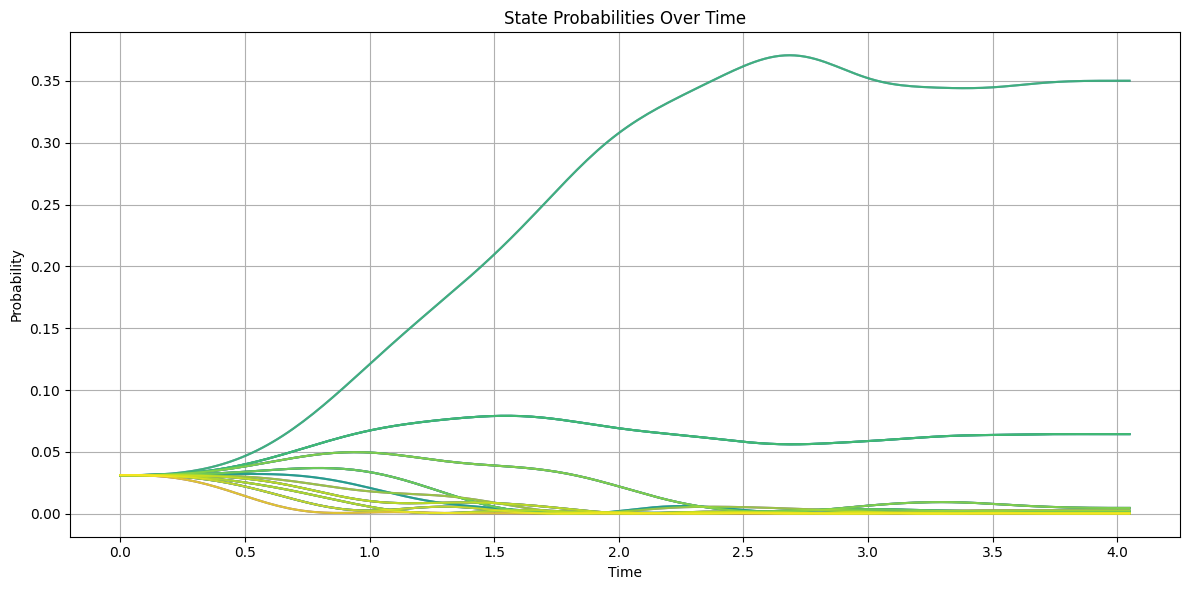

In [21]:
def plot_state_probabilities(states_over_time):
    """
    Plots the evolution of state probabilities over time.

    Parameters:
        states_over_time (list): List of tuples (time, state vector) from adiabatic evolution.
    """
    num_states = len(states_over_time[0][1])
    probabilities_over_time = []
    time_points = []

    for t, state in states_over_time:
        probabilities = np.abs(state)**2
        probabilities_over_time.append(probabilities)
        time_points.append(t)

    probabilities_over_time = np.array(probabilities_over_time)
    time_points = np.array(time_points)

    # Plot state probabilities
    plt.figure(figsize=(12, 6))
    colors = cm.viridis(np.linspace(0, 1, num_states))
    for state_idx in range(num_states):
        plt.plot(time_points, probabilities_over_time[:, state_idx], color=colors[state_idx], alpha=0.8)
    plt.title("State Probabilities Over Time")
    plt.xlabel("Time")
    plt.ylabel("Probability")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot state probabilities
plot_state_probabilities(states_forward)

In [19]:
import numpy as np

class XXZModel:
    def __init__(self, vertices, Jx, Jy, Jz, alpha=2.0):
        """
        Initialize the XXZ Model.
        :param vertices: List of vertices (spin sites).
        :param Jx: Coupling constant for the x direction.
        :param Jy: Coupling constant for the y direction.
        :param Jz: Coupling constant for the z direction.
        :param alpha: Decay exponent for long-range interactions.
        """
        self.vertices = vertices
        self.num_vertices = len(vertices)
        self.edges = [(i, j) for i in range(self.num_vertices) for j in range(i + 1, self.num_vertices)]
        self.Jx = Jx
        self.Jy = Jy
        self.Jz = Jz
        self.alpha = alpha
        self.weights = {
            (i, j): 1.0 / abs(i - j) ** self.alpha
            for i, j in self.edges
        }

    def hamiltonian(self):
        """Define the XXZ Hamiltonian."""
        def hamiltonian(spins):
            # Spins are in {-1, 1}
            S = np.array(spins)
            H_x = 0
            H_y = 0
            H_z = 0

            # Calculate contributions for each pair
            for (i, j), weight in self.weights.items():
                H_x += self.Jx * weight * S[i] * S[j]  # σ^x σ^x
                H_y += self.Jy * weight * S[i] * S[j]  # σ^y σ^y
                H_z += self.Jz * weight * S[i] * S[j]  # σ^z σ^z

            return H_x + H_y + H_z

        return hamiltonian


# Define parameters for the XXZ Model
vertices = [0, 1, 2, 3, 5]  # Four spins
Jx = 1.0  # Coupling constant in x direction
Jy = 1.0  # Coupling constant in y direction
Jz = 2.0  # Coupling constant in z direction
alpha = 2.0  # Power-law decay

# Create the XXZ Model problem
xxz_problem = XXZModel(vertices, Jx, Jy, Jz, alpha)
sim = Simulator(len(vertices), xxz_problem.hamiltonian())

# Classical Simulation
classical_result = sim.classical()
print("Classical Result:", classical_result)

# Adiabatic Evolution
optimal_t = sim.suggest_t()
print(f"Suggested optimal t: {optimal_t}")
states_forward, H_ts_over_time, final_state = sim.adiabatic_evolution(num_steps=200, T=optimal_t)

# Measure the final state
best_spins, best_energy = measure(final_state, sim)
print("Final State Measurement:")
print(f"Best Spins: {best_spins}")
print(f"Best Energy: {best_energy}")


Config 0: Spins = [-1, -1, -1, -1, -1], Energy = 20.13888888888889
Config 1: Spins = [1, -1, -1, -1, -1], Energy = 8.75
Config 2: Spins = [-1, 1, -1, -1, -1], Energy = 1.25
Config 3: Spins = [1, 1, -1, -1, -1], Energy = 5.861111111111111
Config 4: Spins = [-1, -1, 1, -1, -1], Energy = 0.13888888888888928
Config 5: Spins = [1, -1, 1, -1, -1], Energy = -7.25
Config 6: Spins = [-1, 1, 1, -1, -1], Energy = -2.75
Config 7: Spins = [1, 1, 1, -1, -1], Energy = 5.861111111111111
Config 8: Spins = [-1, -1, -1, 1, -1], Energy = 1.25
Config 9: Spins = [1, -1, -1, 1, -1], Energy = -8.36111111111111
Config 10: Spins = [-1, 1, -1, 1, -1], Energy = -13.63888888888889
Config 11: Spins = [1, 1, -1, 1, -1], Energy = -7.25
Config 12: Spins = [-1, -1, 1, 1, -1], Energy = -2.75
Config 13: Spins = [1, -1, 1, 1, -1], Energy = -8.36111111111111
Config 14: Spins = [-1, 1, 1, 1, -1], Energy = -1.6388888888888893
Config 15: Spins = [1, 1, 1, 1, -1], Energy = 8.75
Config 16: Spins = [-1, -1, -1, -1, 1], Energy = 

In [22]:
import numpy as np

class DualHamiltonian:
    def __init__(self, vertices, Jx, Jy, Jz, t):
        """
        Initialize the dual Hamiltonian.
        :param vertices: List of vertices (spin sites).
        :param Jx: Coupling constant for x-direction interactions.
        :param Jy: Coupling constant for y-direction interactions.
        :param Jz: Coupling constant for z-direction interactions.
        :param t: Strength of the on-site Majorana term.
        """
        self.vertices = vertices
        self.num_vertices = len(vertices)
        self.Jx = Jx
        self.Jy = Jy
        self.Jz = Jz
        self.t = t
        self.edges = [(i, (i + 1) % self.num_vertices) for i in range(self.num_vertices)]  # Periodic boundary conditions

    def hamiltonian(self):
        """Define the dual Hamiltonian."""
        def hamiltonian(majoranas_a, majoranas_b):
            """
            :param majoranas_a: Majorana operators γ^a.
            :param majoranas_b: Majorana operators γ^b.
            :return: Energy of the system for given Majorana operator values.
            """
            # Initialize Hamiltonian components
            H_interaction = 0
            H_onsite = 0

            for (i, j) in self.edges:
                # Interaction terms
                H_interaction += (
                    self.Jx * majoranas_a[j] * majoranas_b[i] +
                    self.Jy * majoranas_a[i] * majoranas_b[j] +
                    self.Jz * majoranas_a[i] * majoranas_a[j] * majoranas_b[i] * majoranas_b[j]
                )

            # On-site Majorana term
            for i in range(self.num_vertices):
                H_onsite += self.t / 2 * majoranas_a[i] * majoranas_b[i]

            return H_interaction - H_onsite

        return hamiltonian


# Define parameters for the dual Hamiltonian
vertices = [0, 1, 2, 3]  # Four sites
Jx = 1.0  # Coupling constant in x-direction
Jy = 1.0  # Coupling constant in y-direction
Jz = 1.0  # Coupling constant in z-direction
t = 0.5   # On-site interaction strength

# Create the dual Hamiltonian problem
dual_problem = DualHamiltonian(vertices, Jx, Jy, Jz, t)
hamiltonian = dual_problem.hamiltonian()

# Example Majorana operator values
majoranas_a = np.random.choice([-1, 1], len(vertices))  # Random values in {-1, 1}
majoranas_b = np.random.choice([-1, 1], len(vertices))  # Random values in {-1, 1}

# Evaluate the Hamiltonian for the given Majorana values
energy = hamiltonian(majoranas_a, majoranas_b)
print("Energy:", energy)

sim = Simulator(len(vertices), dual_problem.hamiltonian())

# Classical Simulation
classical_result = sim.classical()
print("Classical Result:", classical_result)

# Adiabatic Evolution
optimal_t = sim.suggest_t()
print(f"Suggested optimal t: {optimal_t}")
states_forward, H_ts_over_time, final_state = sim.adiabatic_evolution(num_steps=200, T=optimal_t)

# Measure the final state
best_spins, best_energy = measure(final_state, sim)
print("Final State Measurement:")
print(f"Best Spins: {best_spins}")
print(f"Best Energy: {best_energy}")


Energy: 4.5
